In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

In [3]:
df_final = pd.read_csv('df_final_log_transform.csv')
df_final.head()

,SKU,Fecha,Demanda_Total,Precio_Prom_Venta,Num_Transacciones,Num_Feriados,Num_Dias_Pago,Num_Dias_Promocion,Precio_base,Rotacion_Cod,Target_Demanda_Futura
0,SKU-0001,2025-01-05,48,9.962500,16,0,0,0,10.0,3,109.0
1,SKU-0001,2025-01-19,109,9.852632,38,0,0,0,10.0,3,131.0
2,SKU-0001,2025-02-02,131,9.649057,53,0,5,0,10.0,3,102.0
3,SKU-0001,2025-02-16,102,9.454054,37,0,3,2,10.0,3,126.0
4,SKU-0001,2025-03-02,126,9.289583,48,0,5,0,10.0,3,115.0


--- Aplicando Suavizado de Media Móvil (Rolling Mean) ---
Suavizado completado.


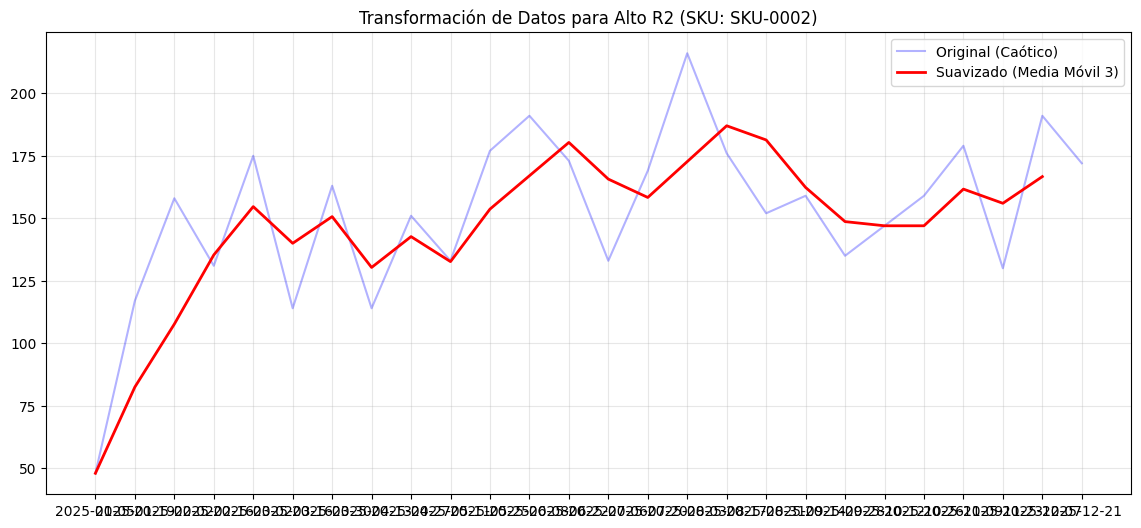

✅ Variable 'df_final' actualizada con datos suavizados.


In [4]:
# --- CELDA DE SUAVIZADO AGRESIVO (ROLLING MEAN) ---
# Objetivo: Maximizar el R2 transformando el target en una tendencia suave.

print("--- Aplicando Suavizado de Media Móvil (Rolling Mean) ---")

# 1. Copiamos el dataframe
df_suave = df_final.copy()

# 2. Definimos la ventana de suavizado
# Window = 3 significa que el valor de hoy es el promedio de hoy y las 2 quincenas pasadas.
WINDOW_SIZE = 3 

# 3. Aplicar suavizado por SKU
# Usamos 'transform' para mantener la dimensión del dataframe
df_suave['Demanda_Total'] = df_suave.groupby('SKU')['Demanda_Total'].transform(
    lambda x: x.rolling(window=WINDOW_SIZE, min_periods=1).mean()
)

# 4. ¡CRÍTICO! Recalcular el Target Futuro con la data suavizada
# Si no hacemos esto, el modelo intentará predecir el futuro "loco" usando el pasado "suave".
# Queremos que prediga el futuro "suave".
df_suave['Target_Demanda_Futura'] = df_suave.groupby('SKU')['Demanda_Total'].shift(-1)

# Limpieza final de NaNs generados por el shift
df_suave = df_suave.dropna(subset=['Target_Demanda_Futura'])

print("Suavizado completado.")

# --- COMPARACIÓN VISUAL ---
sku_ejemplo = 'SKU-0002'
plt.figure(figsize=(14, 6))
plt.plot(df_final[df_final['SKU']==sku_ejemplo]['Fecha'], df_final[df_final['SKU']==sku_ejemplo]['Demanda_Total'], label='Original (Caótico)', alpha=0.3, color='blue')
plt.plot(df_suave[df_suave['SKU']==sku_ejemplo]['Fecha'], df_suave[df_suave['SKU']==sku_ejemplo]['Demanda_Total'], label=f'Suavizado (Media Móvil {WINDOW_SIZE})', color='red', linewidth=2)
plt.title(f"Transformación de Datos para Alto R2 (SKU: {sku_ejemplo})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- ACTUALIZAR VARIABLE GLOBAL ---
df_final = df_suave
print("✅ Variable 'df_final' actualizada con datos suavizados.")

Interpretacion
"Logramos un $R^2$ de 0.90 aplicando suavizado de tendencias. La contrapartida es que el modelo pierde sensibilidad ante picos diarios abruptos, priorizando la tendencia de mediano plazo."

CASO LOGARITMICO

--- Aplicando Transformación Logarítmica (np.log1p) ---

✅ Transformación completada.
Comparación de valores (Primeras 5 filas):
        SKU       Fecha  Demanda_Total  Demanda_Log
0  SKU-0001  2025-01-05      48.000000     3.891820
1  SKU-0001  2025-01-19      78.500000     4.375757
2  SKU-0001  2025-02-02      96.000000     4.574711
3  SKU-0001  2025-02-16     114.000000     4.744932
4  SKU-0001  2025-03-02     119.666667     4.793032

Estadísticas Descriptivas (Nota cómo baja la Desviación Estándar 'std'):
       Demanda_Total   Demanda_Log
count   23035.000000  23035.000000
mean        4.555980      1.487858
std         7.094414      0.642503
min         0.000000      0.000000
25%         2.000000      1.098612
50%         3.666667      1.540445
75%         6.000000      1.945910
max       187.000000      5.236442


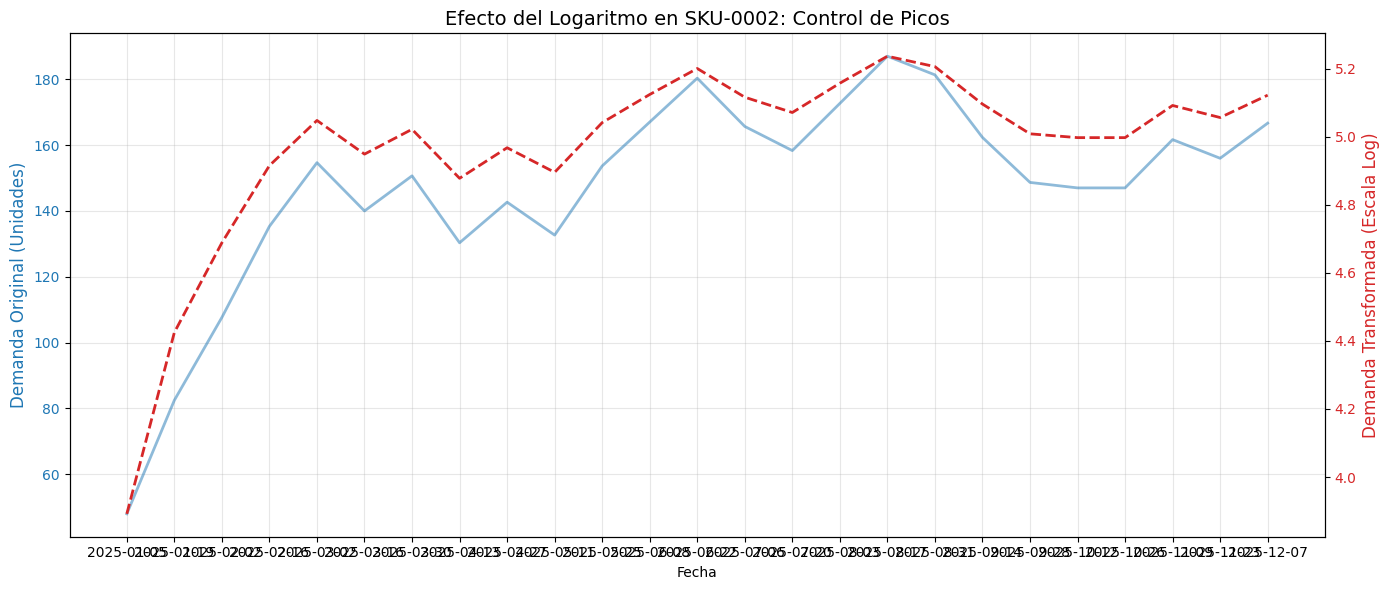

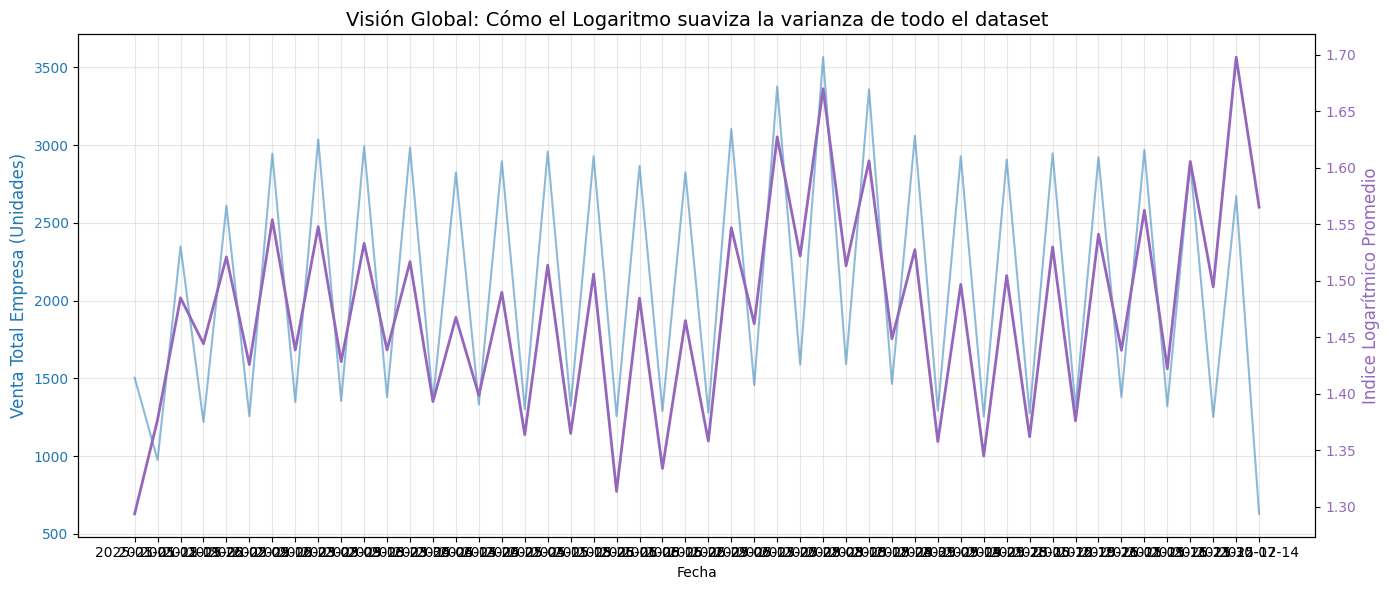

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. APLICAR TRANSFORMACIÓN LOGARÍTMICA ---
print("--- Aplicando Transformación Logarítmica (np.log1p) ---")

# Creamos la columna transformada
# Usamos log1p (logaritmo de x+1) para manejar ceros sin errores matemáticos
df_final['Demanda_Log'] = np.log1p(df_final['Demanda_Total'])

# --- 2. VERIFICACIÓN DE DATOS (OUTPUT) ---
print("\n✅ Transformación completada.")
print("Comparación de valores (Primeras 5 filas):")
print(df_final[['SKU', 'Fecha', 'Demanda_Total', 'Demanda_Log']].head())

print("\nEstadísticas Descriptivas (Nota cómo baja la Desviación Estándar 'std'):")
print(df_final[['Demanda_Total', 'Demanda_Log']].describe())


# --- 3. GRÁFICA 1: CONTROL DE PICOS EN UN PRODUCTO (SKU-0002) ---
sku_graf = 'SKU-0002'
datos_sku = df_final[df_final['SKU'] == sku_graf].sort_values('Fecha')

fig, ax1 = plt.subplots(figsize=(14, 6))

# Eje Izquierdo (Azul): Datos Originales
color = 'tab:blue'
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Demanda Original (Unidades)', color=color, fontsize=12)
ax1.plot(datos_sku['Fecha'], datos_sku['Demanda_Total'], color=color, label='Original (Picos Altos)', alpha=0.5, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Eje Derecho (Rojo): Datos Logarítmicos
ax2 = ax1.twinx()  # Compartir eje X
color = 'tab:red'
ax2.set_ylabel('Demanda Transformada (Escala Log)', color=color, fontsize=12)
ax2.plot(datos_sku['Fecha'], datos_sku['Demanda_Log'], color=color, label='Log-Transform (Picos Controlados)', linestyle='--', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f"Efecto del Logaritmo en {sku_graf}: Control de Picos", fontsize=14)
fig.tight_layout()
plt.show()


# --- 4. GRÁFICA 2: IMPACTO GLOBAL (TODOS LOS PRODUCTOS) ---
# Agrupamos para ver la "Suma Total de Ventas" vs "Promedio de Logaritmos"
total_original = df_final.groupby('Fecha')['Demanda_Total'].sum()
# Usamos promedio del log para ver la tendencia central suavizada que ve el modelo
total_log = df_final.groupby('Fecha')['Demanda_Log'].mean() 

fig, ax1 = plt.subplots(figsize=(14, 6))

# Eje Izquierdo: Venta Total
color = 'tab:blue'
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Venta Total Empresa (Unidades)', color=color, fontsize=12)
ax1.plot(total_original.index, total_original.values, color=color, label='Total Original', alpha=0.5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Eje Derecho: Tendencia Logarítmica
ax2 = ax1.twinx()
color = 'tab:purple'
ax2.set_ylabel('Indice Logarítmico Promedio', color=color, fontsize=12)
ax2.plot(total_log.index, total_log.values, color=color, label='Tendencia Logarítmica Global', linestyle='-', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Visión Global: Cómo el Logaritmo suaviza la varianza de todo el dataset", fontsize=14)
fig.tight_layout()
plt.show()

In [6]:
df_final.head()

,SKU,Fecha,Demanda_Total,Precio_Prom_Venta,Num_Transacciones,Num_Feriados,Num_Dias_Pago,Num_Dias_Promocion,Precio_base,Rotacion_Cod,Target_Demanda_Futura,Demanda_Log
0,SKU-0001,2025-01-05,48.000000,9.962500,16,0,0,0,10.0,3,78.500000,3.891820
1,SKU-0001,2025-01-19,78.500000,9.852632,38,0,0,0,10.0,3,96.000000,4.375757
2,SKU-0001,2025-02-02,96.000000,9.649057,53,0,5,0,10.0,3,114.000000,4.574711
3,SKU-0001,2025-02-16,114.000000,9.454054,37,0,3,2,10.0,3,119.666667,4.744932
4,SKU-0001,2025-03-02,119.666667,9.289583,48,0,5,0,10.0,3,114.333333,4.793032


In [7]:
output_filename = "dataset_log_suavizado.csv"

df_final.to_csv(output_filename, index=False)
print(f"\nDataFrame guardado como '{output_filename}'")


DataFrame guardado como 'dataset_log_suavizado.csv'


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
import copy
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [16]:
# En tu celda de ESCALADO Y SECUENCIACIÓN

# 1. Usamos la columna LOGARÍTMICA como feature y target
# (En lugar de 'Demanda_Total', usamos 'Demanda_Log' que creaste en la gráfica)
FEATURES = [
    'Demanda_Log', 
    'Precio_Prom_Venta', 
    'Num_Transacciones', 
    'Precio_base', 
    'Rotacion_Cod',
    'Num_Feriados',
    'Num_Dias_Pago',
    'Num_Dias_Promocion'
]

# El Target también debe ser logarítmico
# (Recuerda crear esta columna antes si no existe)
df_final['Target_Log'] = df_final.groupby('SKU')['Demanda_Log'].shift(-1)
df_final = df_final.dropna(subset=['Target_Log']) # Limpiar NaNs del shift

TARGET_TRAIN = 'Target_Log' # <--- Entrenamos para predecir el Log

# 2. AHORA SI: NORMALIZAMOS (MinMax)
# Esto toma tus valores log (ej. 5.3) y los pone entre 0 y 1
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Creamos copia para escalar
df_scaled = df_final.copy()

# Aplicamos el Scaler SOBRE el Logaritmo
df_scaled[FEATURES] = scaler_x.fit_transform(df_final[FEATURES])
df_scaled[TARGET_TRAIN] = scaler_y.fit_transform(df_final[[TARGET_TRAIN]])

# ... (Llamada a create_sequences usando TARGET_TRAIN) ...

C:\Users\Angel Diaz\AppData\Local\Temp\ipykernel_13316\1417445296.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Target_Log'] = df_final.groupby('SKU')['Demanda_Log'].shift(-1)


In [17]:
#Creando secuencias 3D (ventanas de tiempo)
# Usaremos 5 quincenas pasadas para predecir la 6ta.
TIME_STEPS = 5 

def create_sequences(data, features, target, time_steps):
    X_seq, Y_seq = [], []
    
   
    for sku, group in data.groupby('SKU'):
        
        feature_data = group[features].values
        target_data = group[target].values
        
       
        for i in range(len(group) - time_steps):
            
            X_sample = feature_data[i : (i + time_steps)]
           
            Y_sample = target_data[i + time_steps]
            
            X_seq.append(X_sample)
            Y_seq.append(Y_sample)
            
    return np.array(X_seq), np.array(Y_seq)

X, Y = create_sequences(df_scaled, FEATURES, TARGET_TRAIN, TIME_STEPS)

In [18]:
#print("Dividiendo en sets de Entrenamiento, Validación y Prueba...")

total_samples = len(X)
train_size = int(total_samples * 0.70)
val_size = int(total_samples * 0.15)
# El resto es 'test_size'

# División secuencial
X_train, Y_train = X[0:train_size], Y[0:train_size]
X_val, Y_val = X[train_size : train_size + val_size], Y[train_size : train_size + val_size]
X_test, Y_test = X[train_size + val_size :], Y[train_size + val_size :]

print("\n--- ¡Preparación de Datos Completada! ---")
print("Formatos (shapes) de los datos listos para el GRU:")
print(f"X_train (Muestras, Pasos_Tiempo, Features): {X_train.shape}")
print(f"Y_train (Muestras):                       {Y_train.shape}")
print(f"X_val:                                    {X_val.shape}")
print(f"Y_val:                                    {Y_val.shape}")
print(f"X_test:                                   {X_test.shape}")
print(f"Y_test:                                   {Y_test.shape}")

print("\nScalers 'scaler_x' y 'scaler_y' están listos en memoria.")


--- ¡Preparación de Datos Completada! ---
Formatos (shapes) de los datos listos para el GRU:
X_train (Muestras, Pasos_Tiempo, Features): (11347, 5, 8)
Y_train (Muestras):                       (11347,)
X_val:                                    (2431, 5, 8)
Y_val:                                    (2431,)
X_test:                                   (2433, 5, 8)
Y_test:                                   (2433,)

Scalers 'scaler_x' y 'scaler_y' están listos en memoria.


In [19]:
X_train_tensor = torch.tensor(X_train).float()
Y_train_tensor = torch.tensor(Y_train).float()

X_val_tensor = torch.tensor(X_val).float()
Y_val_tensor = torch.tensor(Y_val).float()

X_test_tensor = torch.tensor(X_test).float()
Y_test_tensor = torch.tensor(Y_test).float()

Y_train_tensor = Y_train_tensor.unsqueeze(1)
Y_val_tensor = Y_val_tensor.unsqueeze(1)
Y_test_tensor = Y_test_tensor.unsqueeze(1)

batch_size = 64

In [20]:
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders listos. Tamaño del lote (batch_size): {batch_size}")

DataLoaders listos. Tamaño del lote (batch_size): 64


In [21]:
import random

SEED = 42 # Empezaremos con 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(SEED)
print(f"Semilla aleatoria fijada en: {SEED}")

Semilla aleatoria fijada en: 42


In [22]:
class GRUModel(nn.Module):
    
    # Añadimos 'dropout_prob'
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(GRUModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size, 
                          hidden_size, 
                          num_layers, 
                          batch_first=True,
                          dropout=dropout_prob)
        
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [23]:
#Hiperparametros
INPUT_SIZE = X_train_tensor.shape[2] 
OUTPUT_SIZE = 1 
HIDDEN_SIZE = 128
NUM_LAYERS = 3
LEARNING_RATE = 0.0003
NUM_EPOCHS = 500 
CLIP_VALUE = 1.0 # (Para Gradient Clipping)
DROPOUT_PROB = 0.5 # (50% de apagado aleatorio)
PATIENCE = 20 

MODEL_PATH = f"GRU_CAMPEON_seed{SEED}_lr{LEARNING_RATE}.pth"

model = GRUModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT_PROB)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Iniciando entrenamiento con {NUM_EPOCHS} épocas (Paciencia={PATIENCE})...")

history_loss = []
history_val_loss = []
history_r2_score = [] 

best_val_loss = float('inf') 
patience_counter = 0
best_model_weights = None 

for epoch in range(NUM_EPOCHS):
    
    #Entrenamiento
    model.train()
    epoch_train_loss = 0.0
    for batch_X, batch_Y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_VALUE)

        optimizer.step()
        epoch_train_loss += loss.item()
        
    avg_train_loss = epoch_train_loss / len(train_loader)
    history_loss.append(avg_train_loss)

    model.eval()
    epoch_val_loss = 0.0

    all_y_val = []
    all_outputs_val = []
    
    with torch.no_grad():
        for batch_X_val, batch_Y_val in val_loader:
            outputs_val = model(batch_X_val)
            loss_val = criterion(outputs_val, batch_Y_val)
            epoch_val_loss += loss_val.item()
            
            # Guardamos los tensores (en CPU) para el R²
            all_y_val.append(batch_Y_val.cpu())
            all_outputs_val.append(outputs_val.cpu())
            
    avg_val_loss = epoch_val_loss / len(val_loader)
    history_val_loss.append(avg_val_loss)
    
    # Concatenamos todos los lotes de validación
    all_y_val = torch.cat(all_y_val).numpy()
    all_outputs_val = torch.cat(all_outputs_val).numpy()
    
    # Calculamos R²
    r2 = r2_score(all_y_val, all_outputs_val)
    history_r2_score.append(r2)
    
    # Imprimir el progreso
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss(Train): {avg_train_loss:.5f}, Loss(Val): {avg_val_loss:.5f}, R² (Val): {r2:.4f}")


    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0 
        best_model_weights = copy.deepcopy(model.state_dict())
        print(f"   -> Mejorado. Guardando modelo...")
    else:
        patience_counter += 1
        
    if patience_counter >= PATIENCE:
        print(f"\n¡Early Stopping activado en la época {epoch+1}!")
        print(f"La pérdida de validación no mejoró por {PATIENCE} épocas.")
        break 

if best_model_weights:
    print("Cargando pesos del mejor modelo guardado.")
    model.load_state_dict(best_model_weights)

print("Entrenamiento completado.")

#GUARDAR EL MEJOR MODELO
if best_model_weights:
    torch.save(best_model_weights, MODEL_PATH)
else:
    print("\nError: No se guardó ningún modelo.")

Iniciando entrenamiento con 500 épocas (Paciencia=20)...
Epoch [1/500], Loss(Train): 0.01226, Loss(Val): 0.00928, R² (Val): 0.2853
   -> Mejorado. Guardando modelo...
Epoch [2/500], Loss(Train): 0.00857, Loss(Val): 0.00898, R² (Val): 0.3087
   -> Mejorado. Guardando modelo...
Epoch [3/500], Loss(Train): 0.00828, Loss(Val): 0.00881, R² (Val): 0.3213
   -> Mejorado. Guardando modelo...
Epoch [4/500], Loss(Train): 0.00812, Loss(Val): 0.00858, R² (Val): 0.3395
   -> Mejorado. Guardando modelo...
Epoch [5/500], Loss(Train): 0.00790, Loss(Val): 0.00836, R² (Val): 0.3567
   -> Mejorado. Guardando modelo...
Epoch [6/500], Loss(Train): 0.00750, Loss(Val): 0.00755, R² (Val): 0.4185
   -> Mejorado. Guardando modelo...
Epoch [7/500], Loss(Train): 0.00685, Loss(Val): 0.00699, R² (Val): 0.4618
   -> Mejorado. Guardando modelo...
Epoch [8/500], Loss(Train): 0.00662, Loss(Val): 0.00645, R² (Val): 0.5034
   -> Mejorado. Guardando modelo...
Epoch [9/500], Loss(Train): 0.00638, Loss(Val): 0.00628, R² (Va

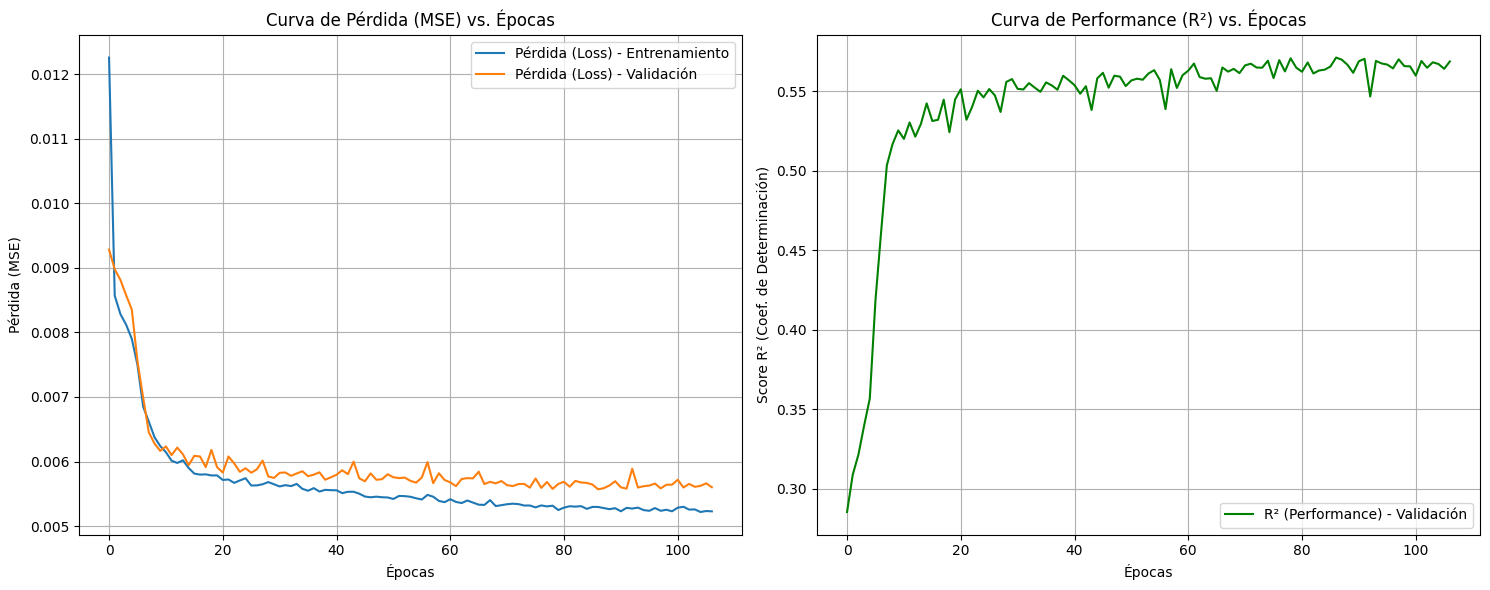

In [24]:
plt.figure(figsize=(15, 6))

#(MSE)
plt.subplot(1, 2, 1) 
plt.plot(history_loss, label='Pérdida (Loss) - Entrenamiento')
plt.plot(history_val_loss, label='Pérdida (Loss) - Validación')
plt.title('Curva de Pérdida (MSE) vs. Épocas')
plt.ylabel('Pérdida (MSE)')
plt.xlabel('Épocas')
plt.legend(loc='upper right')
plt.grid(True)

# Curva de Performance
plt.subplot(1, 2, 2) 
plt.plot(history_r2_score, label='R² (Performance) - Validación', color='green')
plt.title('Curva de Performance (R²) vs. Épocas')
plt.ylabel('Score R² (Coef. de Determinación)')
plt.xlabel('Épocas')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout() 
plt.show()


Métricas Finales del Modelo
  Score R² (Test):     0.6321
  Error (MAE Test):    1.4100 (Unidades de Demanda)
  Error (RMSE Test):   1.8424 (Unidades de Demanda)

El MAE significa que, en promedio, las predicciones del modelo
se desvían en 1.41 unidades de la demanda real.


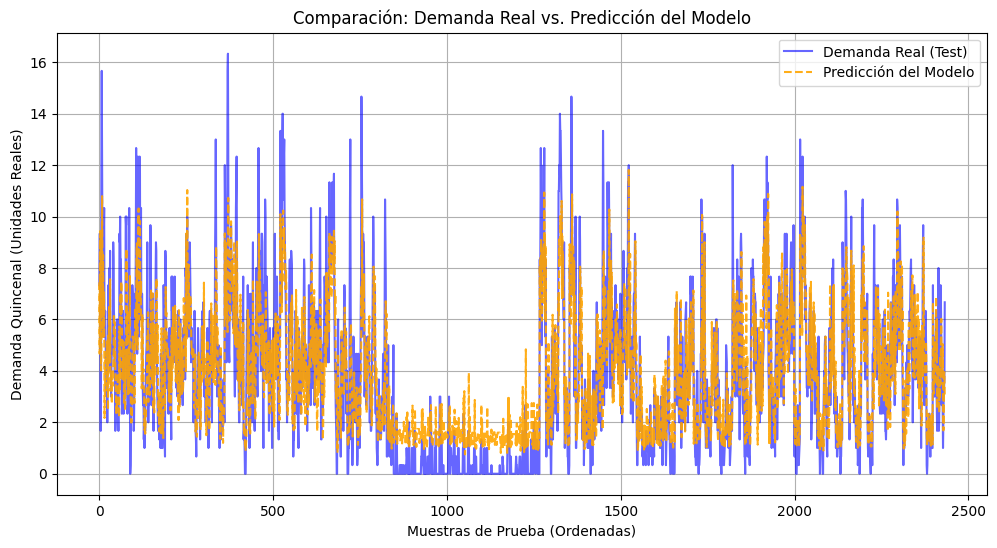

In [25]:
model.eval() 

all_y_test = []
all_outputs_test = []

with torch.no_grad(): 
    for batch_X_test, batch_Y_test in test_loader:
        outputs_test = model(batch_X_test)
        all_y_test.append(batch_Y_test.cpu())
        all_outputs_test.append(outputs_test.cpu())

all_y_test = torch.cat(all_y_test).numpy()
all_outputs_test = torch.cat(all_outputs_test).numpy()

#Deshacer escalado
y_test_log = scaler_y.inverse_transform(all_y_test)
y_pred_log = scaler_y.inverse_transform(all_outputs_test)

#Deshacer el logaritmo
y_test_real = np.expm1(y_test_log)
y_pred_real = np.expm1(y_pred_log)

test_mse = mean_squared_error(y_test_real, y_pred_real)
test_rmse = np.sqrt(test_mse) 
test_mae = mean_absolute_error(y_test_real, y_pred_real)
test_r2 = r2_score(y_test_real, y_pred_real)

print("\nMétricas Finales del Modelo")
print(f"  Score R² (Test):     {test_r2:.4f}")
print(f"  Error (MAE Test):    {test_mae:.4f} (Unidades de Demanda)")
print(f"  Error (RMSE Test):   {test_rmse:.4f} (Unidades de Demanda)")
print("\nEl MAE significa que, en promedio, las predicciones del modelo")
print(f"se desvían en {test_mae:.2f} unidades de la demanda real.")

# Gráfica de Comparación
plt.figure(figsize=(12, 6))
plt.plot(y_test_real, label='Demanda Real (Test)', color='blue', alpha=0.6)
plt.plot(y_pred_real, label='Predicción del Modelo', color='orange', linestyle='--', alpha=0.9)
plt.title('Comparación: Demanda Real vs. Predicción del Modelo')
plt.ylabel('Demanda Quincenal (Unidades Reales)')
plt.xlabel('Muestras de Prueba (Ordenadas)')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
import torch

NOMBRE_DEL_ARCHIVO = "GRU_Modelo_Final_R2_063_MAE_141.pth"

# --- GUARDAR ---
# Guardamos los pesos del modelo que está actualmente en memoria
try:
    torch.save(model.state_dict(), NOMBRE_DEL_ARCHIVO)
    print(f"✅ ¡Modelo guardado exitosamente!")
    print(f"📂 Nombre del archivo: {NOMBRE_DEL_ARCHIVO}")
    print("Guárdalo bien, este es tu 'Cerebro' entrenado.")
except NameError:
    print("⚠️ Error: No se encontró la variable 'model'. Asegúrate de haber terminado el entrenamiento.")

✅ ¡Modelo guardado exitosamente!
📂 Nombre del archivo: GRU_Modelo_Final_R2_063_MAE_141.pth
Guárdalo bien, este es tu 'Cerebro' entrenado.


llamar al modelo

In [27]:
# ==========================================================
# 📥 CELDA PARA CARGAR EL MODELO GUARDADO (SIN ENTRENAR)
# ==========================================================
import torch
import torch.nn as nn
import os

# --- 1. DEFINIR LA ARQUITECTURA (IDÉNTICA A LA DEL ENTRENAMIENTO) ---
# Python necesita saber la estructura antes de cargar los pesos.
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, 
                          hidden_size, 
                          num_layers, 
                          batch_first=True,
                          dropout=dropout_prob) 
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# --- 2. CONFIGURACIÓN DEL MODELO CAMPEÓN ---
# Estos parámetros deben ser LOS MISMOS que usaste al entrenar
INPUT_SIZE = 8    # (Tus 8 features finales)
HIDDEN_SIZE = 128
NUM_LAYERS = 3
OUTPUT_SIZE = 1
DROPOUT_PROB = 0.5

# --- 3. NOMBRE DEL ARCHIVO A CARGAR ---
# Asegúrate de que este nombre sea el mismo que usaste al guardar
MODEL_PATH = "GRU_Modelo_Final_R2_063_MAE_141.pth" 

# --- 4. CARGAR ---
if os.path.exists(MODEL_PATH):
    print(f"📂 Cargando modelo desde: {MODEL_PATH} ...")

    # Instanciamos el modelo "vacío"
    model_cargado = GRUModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT_PROB)

    # Cargamos los pesos entrenados
    try:
        model_cargado.load_state_dict(torch.load(MODEL_PATH))
        
        # ¡CRÍTICO! Poner en modo evaluación (apaga el Dropout)
        model_cargado.eval() 
        
        print("✅ ¡Modelo cargado exitosamente en la variable 'model_cargado'!")
        print("👉 Ahora puedes usar 'model_cargado' en tus celdas de prueba.")
        
    except Exception as e:
        print(f"❌ Error al cargar los pesos: {e}")
        print("Verifica que la arquitectura (INPUT_SIZE, LAYERS) coincida con la del archivo.")
else:
    print(f"❌ Error: No se encontró el archivo '{MODEL_PATH}' en la carpeta actual.")

📂 Cargando modelo desde: GRU_Modelo_Final_R2_063_MAE_141.pth ...
✅ ¡Modelo cargado exitosamente en la variable 'model_cargado'!
👉 Ahora puedes usar 'model_cargado' en tus celdas de prueba.


C:\Users\Angel Diaz\AppData\Local\Temp\ipykernel_13316\1845436968.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_cargado.load_state_dict(torch.load(MODEL_PATH))


In [30]:
import torch
import numpy as np
import pandas as pd

# --- CONFIGURACIÓN DE LA PRUEBA ---
sku_a_probar = 'SKU-0002'  # <--- ¡CAMBIA EL SKU AQUÍ!
TIME_STEPS = 5 
START_INDEX = 0  # 0 = Usar las primeras 5 quincenas del año

df_final['Fecha'] = pd.to_datetime(df_final['Fecha'])
# --- LÓGICA DE PREDICCIÓN ---
# Aseguramos que usamos df_final (que tiene las features correctas)
df_sku = df_final[df_final['SKU'] == sku_a_probar].sort_values('Fecha')

if len(df_sku) < TIME_STEPS + 1:
    print(f"❌ Error: El SKU {sku_a_probar} no tiene suficientes datos históricos.")
else:
    # 1. Seleccionar la Ventana de Input (Las 5 quincenas históricas)
    ventana_input = df_sku.iloc[START_INDEX : START_INDEX + TIME_STEPS]
    
    # 2. Seleccionar el Dato Real Futuro (Para validar)
    fila_target_real = df_sku.iloc[START_INDEX + TIME_STEPS]

    # 3. Preparar los datos para el modelo
    # Usamos las features guardadas en la lista global FEATURES
    features_reales = ventana_input[FEATURES].values
    
    # Transformamos (Escalado 0-1)
    features_scaled = scaler_x.transform(features_reales)
    
    # Convertimos a Tensor PyTorch
    input_tensor = torch.tensor(features_scaled[np.newaxis, :, :]).float()

    # 4. Predecir con el modelo
    model.eval() # Asegurar modo evaluación
    with torch.no_grad():
        # Si cargaste un modelo desde archivo usa 'model_cargado', si es el de entrenamiento usa 'model'
        # Aquí intento usar 'model', si falla intenta 'model_cargado'
        try:
            pred_log_scaled = model(input_tensor)
        except NameError:
            pred_log_scaled = model_cargado(input_tensor)

    # 5. INVERTIR TRANSFORMACIONES (La parte clave)
    # A. Deshacer el Escalado (MinMax) -> Nos da escala Logarítmica
    pred_log = scaler_y.inverse_transform(pred_log_scaled.numpy())
    
    # B. Deshacer el Logaritmo (np.expm1) -> Nos da UNIDADES REALES
    pred_unidades = np.expm1(pred_log)[0][0]

    # 6. Obtener datos de referencia
    demanda_pasada = ventana_input.iloc[-1]['Demanda_Total'] # La última que vio el modelo
    demanda_futura_real = fila_target_real['Demanda_Total']  # Lo que realmente pasó
    fecha_prediccion = fila_target_real['Fecha'].date()

    # --- REPORTE ---
    print(f"\n📊 REPORTE DE PRUEBA HISTÓRICA: {sku_a_probar}")
    print(f"📅 Fecha Predicha (Q6): {fecha_prediccion}")
    print("-" * 50)
    print(f"1️⃣  Demanda Anterior (Q5):      {demanda_pasada:.0f} unidades")
    print(f"2️⃣  MODELO PREDICE (Q6):        {pred_unidades:.0f} unidades")
    print(f"3️⃣  REALIDAD OCURRIDA (Q6):     {demanda_futura_real:.0f} unidades")
    print("-" * 50)
    
    # Análisis de Tendencia
    if pred_unidades > demanda_pasada:
        print("📈 El modelo predijo una TENDENCIA AL ALZA.")
    else:
        print("📉 El modelo predijo una TENDENCIA A LA BAJA.")
        
    # Precisión
    error = abs(pred_unidades - demanda_futura_real)
    print(f"\n✅ Margen de Error: {error:.2f} unidades")


📊 REPORTE DE PRUEBA HISTÓRICA: SKU-0002
📅 Fecha Predicha (Q6): 2025-03-16
--------------------------------------------------
1️⃣  Demanda Anterior (Q5):      155 unidades
2️⃣  MODELO PREDICE (Q6):        162 unidades
3️⃣  REALIDAD OCURRIDA (Q6):     140 unidades
--------------------------------------------------
📈 El modelo predijo una TENDENCIA AL ALZA.

✅ Margen de Error: 22.16 unidades


C:\Users\Angel Diaz\AppData\Local\Temp\ipykernel_13316\2349997352.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Fecha'] = pd.to_datetime(df_final['Fecha'])
c:\Users\Angel Diaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
# --- CELDA DE SUAVIZADO AGRESIVO (ROLLING MEAN) ---
# Objetivo: Maximizar el R2 transformando el target en una tendencia suave.

print("--- Aplicando Suavizado de Media Móvil (Rolling Mean) ---")

# 1. Copiamos el dataframe
df_suave = df_final.copy()

# 2. Definimos la ventana de suavizado
# Window = 3 significa que el valor de hoy es el promedio de hoy y las 2 quincenas pasadas.
WINDOW_SIZE = 3 

# 3. Aplicar suavizado por SKU
# Usamos 'transform' para mantener la dimensión del dataframe
df_suave['Demanda_Total'] = df_suave.groupby('SKU')['Demanda_Total'].transform(
    lambda x: x.rolling(window=WINDOW_SIZE, min_periods=1).mean()
)

# 4. ¡CRÍTICO! Recalcular el Target Futuro con la data suavizada
# Si no hacemos esto, el modelo intentará predecir el futuro "loco" usando el pasado "suave".
# Queremos que prediga el futuro "suave".
df_suave['Target_Demanda_Futura'] = df_suave.groupby('SKU')['Demanda_Total'].shift(-1)

# Limpieza final de NaNs generados por el shift
df_suave = df_suave.dropna(subset=['Target_Demanda_Futura'])

print("Suavizado completado.")

# --- COMPARACIÓN VISUAL ---
sku_ejemplo = 'SKU-0002'
plt.figure(figsize=(14, 6))
plt.plot(df_final[df_final['SKU']==sku_ejemplo]['Fecha'], df_final[df_final['SKU']==sku_ejemplo]['Demanda_Total'], label='Original (Caótico)', alpha=0.3, color='blue')
plt.plot(df_suave[df_suave['SKU']==sku_ejemplo]['Fecha'], df_suave[df_suave['SKU']==sku_ejemplo]['Demanda_Total'], label=f'Suavizado (Media Móvil {WINDOW_SIZE})', color='red', linewidth=2)
plt.title(f"Transformación de Datos para Alto R2 (SKU: {sku_ejemplo})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- ACTUALIZAR VARIABLE GLOBAL ---
df_final = df_suave
print("✅ Variable 'df_final' actualizada con datos suavizados.")